# 猫狗大战

In [13]:
import os
import csv
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from sklearn.utils import shuffle
from keras.preprocessing import image
from keras.models import Model, Sequential
from keras.utils.visualize_util import plot
from keras.layers import Dense, GlobalAveragePooling2D, Input, Lambda
from keras.applications.inception_v3 import InceptionV3, preprocess_input

## 输入数据

In [2]:
#导入图片并将图片大小统一
generator = image.ImageDataGenerator()
train_generator = generator.flow_from_directory("train_image", (299,299), shuffle=False, 
                                          batch_size=16)
test_generator = generator.flow_from_directory("test_image", (299,299), shuffle=False, 
                                         batch_size=16, class_mode=None)

Found 25000 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.


## 建立模型

In [3]:
input_tensor = Input((299, 299, 3))
#将图片归一化
input_tensor = Lambda(preprocess_input)(input_tensor)
base_model = InceptionV3(input_tensor=input_tensor,weights='imagenet', include_top=False)
x = base_model.output
x = GlobalAveragePooling2D()(x)
model = Model(base_model.input, x)

X_train = model.predict_generator(train_generator, train_generator.nb_sample)
X_test = model.predict_generator(test_generator, test_generator.nb_sample)
y_train=train_generator.classes

input_tensor = Input(X_train.shape[1:])
x = Dense(1024, activation='relu')(input_tensor)
x = Dense(1, activation='sigmoid')(x)
model = Model(input_tensor, x)

model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [4]:
#打乱训练数据顺序
X_train, y_train = shuffle(X_train, y_train)

## 训练模型

In [16]:
model_trian = model.fit(X_train, y_train, batch_size=128, nb_epoch=8, validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/8
20000/20000 [==============================] - 1s - loss: 0.0041 - acc: 0.9996 - val_loss: 0.0353 - val_acc: 0.9914

## 可视化

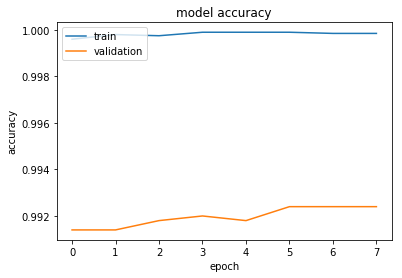

In [17]:
# 准确率可视化
plt.plot(model_trian.history['acc'])
plt.plot(model_trian.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('acc.png')
plt.show()

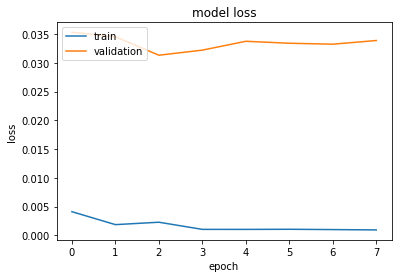

In [18]:
# 损失可视化
plt.plot(model_trian.history['loss'])
plt.plot(model_trian.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('loss.png')
plt.show()

## 测试数据

In [19]:
y_pred = model.predict(X_test, verbose=1)
y_pred = y_pred.clip(min=0.005, max=0.995)

11616/12500 [==========================>...] - ETA: 0s 

## 导出csv文件

In [ ]:
test_filenames = os.listdir('test_image/test/')
test_num = map(lambda x:x[:-4],test_filenames)

filename = 'cat_vs_dog.csv'
try:
    csvfile = open(filename,'w')
    writer = csv.writer(csvfile)
    writer.writerow(['id','label'])
    csv_data = []
    for id_num in range(1,len(test_num)+1):
        for i in range(0,len(test_num)):
            if id_num == int(test_num[i]):
                csv_data.append((id_num,y_pred[i][0]))
    writer.writerows(csv_data)
    print '成功导出cvs文件！'
finally:
    csvfile.close()